In [1]:
import os
import pandas as pd
import numpy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import imagesize
from torchvision import datasets, models, transforms
import seaborn as sns
from PIL import Image
from PIL.ImageFile import ImageFile
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.profiler import profile, record_function, ProfilerActivity
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
import time
import torch.nn.functional as F

In [2]:
#vars
ImageFile.LOAD_TRUNCATED_IMAGES = True

#batch_size = 128
n_epochs = 20
validation_split = .15
images_for_train = 30000
print_every = 100

optimizer_name = "Adagrad"
batch_size = 64
lr = 0.001974473
model_name = "efficientnet_b3"

name_training = "efficientnet_b3_training_wi"
os.mkdir(name_training)

In [3]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:

ImageFile.LOAD_TRUNCATED_IMAGES = True
print(device)
print(torch.cuda.get_device_name(3))

cuda:3
NVIDIA RTX A6000


In [4]:
data_path = "data"
#data_path = "D:\Studium\OneDrive - Hochschule Karlsruhe\own-pictures"

image = []
labels = []
width = []
height = []

for file in os.listdir(data_path):
    # if file == 'elektromuell':
    #     for c in os.listdir(os.path.join(data_path, file)):
    #         image.append(c)
    #         labels.append('elektromuell')
    #         w, h = imagesize.get(data_path + "/" + file + "/" + c)
    #         width.append(w), height.append(h)
    if file == 'glas':
        for c in os.listdir(os.path.join(data_path, file)):
            image.append(c)
            labels.append('glas')
            w, h = imagesize.get(data_path + "/" + file + "/" + c)
            width.append(w), height.append(h)
    if file == 'organic':
        for c in os.listdir(os.path.join(data_path, file)):
            image.append(c)
            labels.append('organic')
            w, h = imagesize.get(data_path + "/" + file + "/" + c)
            width.append(w), height.append(h)
    if file == 'paper':
        for c in os.listdir(os.path.join(data_path, file)):
            image.append(c)
            labels.append('paper')
            w, h = imagesize.get(data_path + "/" + file + "/" + c)
            width.append(w), height.append(h)
    if file == 'restmuell':
        for c in os.listdir(os.path.join(data_path, file)):
            image.append(c)
            labels.append('restmuell')
            w, h = imagesize.get(data_path + "/" + file + "/" + c)
            width.append(w), height.append(h)
    if file == 'wertstoff':
        for c in os.listdir(os.path.join(data_path, file)):
            image.append(c)
            labels.append('wertstoff')
            w, h = imagesize.get(data_path + "/" + file + "/" + c)
            width.append(w), height.append(h)

data = {'Images': image, 'labels': labels, 'width': width, 'height': height}
data = pd.DataFrame(data)
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

In [5]:
data = data.sample(frac=1).reset_index(drop=True)
data = data.head(images_for_train)
tr, val = train_test_split(data, stratify=data.labels, test_size=validation_split)
tr.reset_index(drop=True)
val.reset_index(drop=True)
print(val)

                        Images     labels  width  height  encoded_labels
13418         paper (6320).jpg      paper   5312    2988               2
3131      restmuell (5506).jpg  restmuell    400     534               3
9429   IMG_20220322_101954.jpg  wertstoff   2976    2976               4
18055             paper398.jpg      paper   4032    3024               2
1837      abrakadabra (88).jpg  wertstoff    275     183               4
...                        ...        ...    ...     ...             ...
9001            plastic107.jpg  wertstoff   4032    3024               4
5459        organic (2828).jpg    organic    258     195               1
11791         cardboard220.jpg      paper   3264    2448               2
1339      restmuell (3916).jpg  restmuell    400     711               3
1652          glass (5905).jpg       glas    225     225               0

[3415 rows x 5 columns]


In [6]:
waste_types_df = tr[['encoded_labels', 'labels']].drop_duplicates().sort_values(by='encoded_labels').reset_index(drop=True)
garbage_types = {}
for i in range(0, len(waste_types_df)):
    garbage_types[i] = waste_types_df.iloc[i].labels
print(garbage_types)

{0: 'glas', 1: 'organic', 2: 'paper', 3: 'restmuell', 4: 'wertstoff'}


In [7]:
data

,Images,labels,width,height,encoded_labels
0,restmuell (3681).jpg,restmuell,400,533,3
1,restmuell (4444).jpg,restmuell,533,400,3
2,restmuell (1249).jpg,restmuell,400,533,3
3,glass (4496).jpg,glas,225,225,0
4,organic (3002).jpg,organic,212,237,1
...,...,...,...,...,...
22759,wertstoff (7330).jpg,wertstoff,285,177,4
22760,glass (3674).jpg,glas,284,177,0
22761,restmuell (9289).jpg,restmuell,1127,778,3
22762,paper167.jpg,paper,4032,3024,2


In [8]:
from torchvision import transforms

transform_tr = transforms.Compose(
    [transforms.Resize((300,300), interpolation= transforms.InterpolationMode.BICUBIC),
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.RandomRotation(10),
     transforms.CenterCrop(256),
     #transforms.Resize((300,300), interpolation= transforms.InterpolationMode.BICUBIC),

     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
transform_val = transforms.Compose(
    [transforms.Resize((256,256), interpolation= transforms.InterpolationMode.BICUBIC),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

In [9]:
from torch.utils.data import Dataset

class GarbageDataset(Dataset):
    def __init__(self, img_data, img_path, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, index):
        img_name = os.path.join(self.img_path, self.img_data.iloc[index].labels, self.img_data.iloc[index].Images)
        image = Image.open(img_name).convert('RGB')
        #image = image.resize((300, 300))
        label = torch.tensor(self.img_data.iloc[index].encoded_labels)
        if self.transform is not None:
            image = self.transform(image)
        return image, label, img_name

In [10]:
from torch.utils.data import DataLoader

train_dataset = GarbageDataset(tr, data_path, transform_tr)
test_dataset = GarbageDataset(val, data_path, transform_val)


In [11]:
import numpy as np

def img_display(img):
    MEAN = torch.tensor([0.485, 0.456, 0.406])
    STD = torch.tensor([0.229, 0.224, 0.225])

    img = img * STD[:, None, None] + MEAN[:, None, None]
    #img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg


In [12]:
def accuracy(out, labels):
    _, pred = torch.max(out, dim=1)
    return torch.sum(pred == labels).item()

In [13]:
class SSWQ_V1(nn.Module):
    def __init__(self, num_classes, dropout=0.5, hidden_layer1=2048, hidden_layer2=2048):
        super(SSWQ_V1, self).__init__()
        self.dropout = dropout
        self.hidden_layer1 = hidden_layer1
        self.hidden_layer2 = hidden_layer2
        self.num_classes = num_classes

        self.conv0 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, padding=1)

        self.conv1_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv1_3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv1_4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv2_3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv2_4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(512*7*7, self.hidden_layer1)
        self.fc2 = nn.Linear(self.hidden_layer1, self.hidden_layer2)
        self.fc3 = nn.Linear(self.hidden_layer2, self.num_classes)

    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = self.maxpool(x)
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.relu(self.conv1_3(x))
        #x = F.relu(self.conv1_4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        #x = F.relu(self.conv2_3(x))
        #x = F.relu(self.conv2_4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        #x = F.relu(self.conv3_3(x))
        #x = F.relu(self.conv3_4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        #x = F.relu(self.conv4_4(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, self.dropout) #dropout was included to combat overfitting
        x = F.relu(self.fc2(x))
        x = F.dropout(x, self.dropout)
        x = self.fc3(x)
        return x

In [14]:
def get_model(model_name):
    if model_name == "resnet18":
        model = models.resnet18(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, len(waste_types_df))
    elif model_name == "alexnet":
        model = models.alexnet(pretrained=True)
        in_features = model.classifier[1].in_features
        model.classifier = nn.Linear(in_features, len(waste_types_df))
    elif model_name == "vgg16":
        model = models.vgg16(pretrained=True)
        in_features = model.classifier[0].in_features
        model.classifier = nn.Linear(in_features, len(waste_types_df))
    elif model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, len(waste_types_df))
    elif model_name == "resnet34":
        model = models.resnet34(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, len(waste_types_df))
    elif model_name == "efficientnet_b3":
        model = EfficientNet.from_pretrained("efficientnet-b3",num_classes=len(waste_types_df))
    elif model_name == "efficientnet_b4":
        model = EfficientNet.from_pretrained("efficientnet-b4",num_classes=len(waste_types_df))
    return model

In [15]:

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=7, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=7, pin_memory=True)
def train_model(net, criterion, optimizer, num_epochs,step_size=7, gamma=0.1):
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    time_per_epoch = []
    val_loss = []
    val_acc = []
    train_loss = []
    train_acc = []
    valid_loss_min = np.Inf
    total_step = len(train_dataloader)
    
    for epoch in range(1, num_epochs + 1):
        start = time.time()
        running_loss = 0.0
        correct = 0
        total = 0
        print(f'Epoch {epoch}\n')
        for batch_idx, (data_, target_, _) in enumerate(train_dataloader):
            target_ = target_.type(torch.LongTensor)
            data_, target_ = data_.to(device, non_blocking=True), target_.to(device, non_blocking=True)
            # zero the parameter gradients
            for param in net.parameters():
                param.grad = None
            #optimizer.zero_grad()
            outputs = net(data_)
            loss = criterion(outputs, target_)

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            _, pred = torch.max(outputs, dim=1)
            correct += torch.sum(pred == target_).item()
            total += target_.size(0)
            #if batch_idx % print_every == 0:
            #print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs, batch_idx, total_step, loss.item()))
        train_acc.append(100 * correct / total)
        train_loss.append(running_loss / total_step)
        print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
        batch_loss = 0
        total_t = 0
        correct_t = 0
        with torch.no_grad():
            net.eval()
            for data_t, target_t, _ in (test_dataloader):
                target_t = target_t.type(torch.LongTensor)
                data_t, target_t = data_t.to(device), target_t.to(device)  # on GPU
                outputs_t = net(data_t)
                loss_t = criterion(outputs_t, target_t)
                batch_loss += loss_t.item()
                _, pred_t = torch.max(outputs_t, dim=1)
                correct_t += torch.sum(pred_t == target_t).item()
                total_t += target_t.size(0)
            val_acc.append(100 * correct_t / total_t)
            val_loss.append(batch_loss / len(test_dataloader))
            network_learned = batch_loss < valid_loss_min
            print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
            # Saving the best weight
            if network_learned:
                valid_loss_min = batch_loss
                torch.save(net.state_dict(), name_training + '/model.pt')
                print('Detected network improvement, saving current model')

        net.train()
        exp_lr_scheduler.step()
        end = time.time()
        time_per_epoch.append(round((end-start),2))
        print("Time for this epoch: " + str(round((end-start),2)) + "s")
    return val_loss, val_acc, train_loss, train_acc, time_per_epoch

In [16]:
# Get pretrained model
model = get_model(model_name)
#model = SSWQ_V1(len(waste_types_df), dropout=0.5, 
                #hidden_layer1=512, hidden_layer2=2048)
model = model.to(device)

# Define criterion
criterion = nn.CrossEntropyLoss()

# Configure optimizer
optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
# Train a model
val_loss,val_acc, train_loss, train_acc, time_per_epoch = train_model(model, criterion, optimizer, num_epochs=n_epochs)


Loaded pretrained weights for efficientnet-b3
Epoch 1


train loss: 0.2212, train acc: 92.2735
validation loss: 0.1047, validation acc: 96.5739

Detected network improvement, saving current model
Time for this epoch: 146.64s
Epoch 2


train loss: 0.1529, train acc: 97.2195
validation loss: 0.0912, validation acc: 97.3939

Detected network improvement, saving current model
Time for this epoch: 151.49s
Epoch 3


train loss: 0.1203, train acc: 98.2686
validation loss: 0.0854, validation acc: 97.6574

Detected network improvement, saving current model
Time for this epoch: 149.91s
Epoch 4


train loss: 0.1006, train acc: 98.6201
validation loss: 0.0812, validation acc: 97.5403

Detected network improvement, saving current model
Time for this epoch: 142.9s
Epoch 5


train loss: 0.0870, train acc: 98.9095
validation loss: 0.0795, validation acc: 97.5988

Time for this epoch: 152.9s
Epoch 6


train loss: 0.0767, train acc: 99.1472
validation loss: 0.0785, validation acc: 97.7452

Time for this

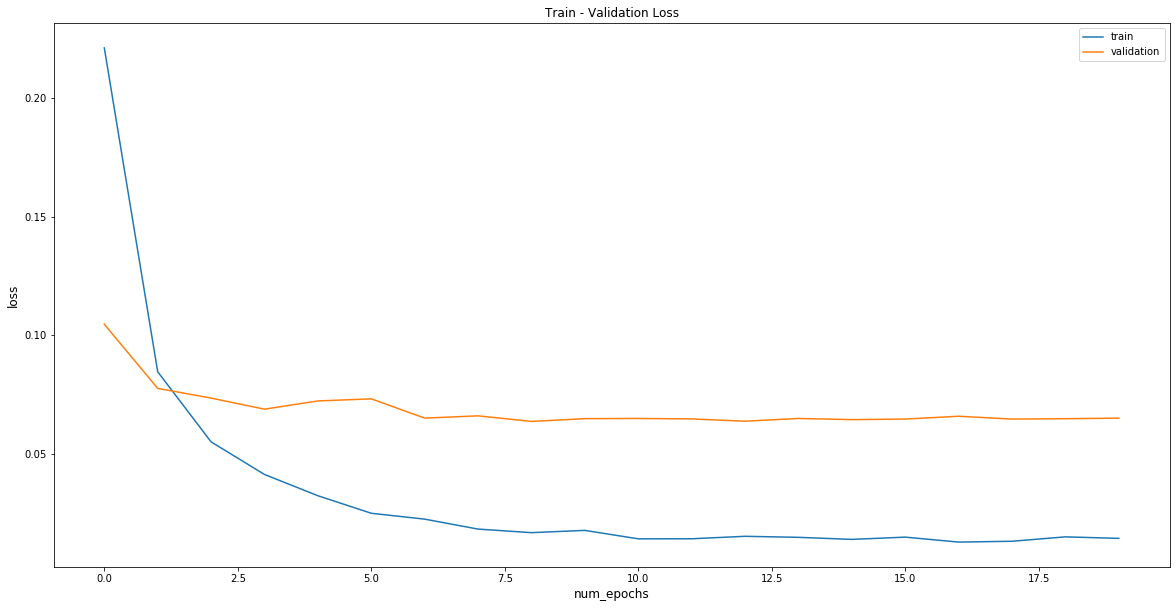

In [17]:
fig_loss = plt.figure(figsize=(20, 10))
plt.title("Train - Validation Loss")
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')
plt.savefig(name_training + '/loss.png', format='png',bbox_inches='tight')
plt.savefig(name_training + '/loss.pdf', format='pdf',bbox_inches='tight')

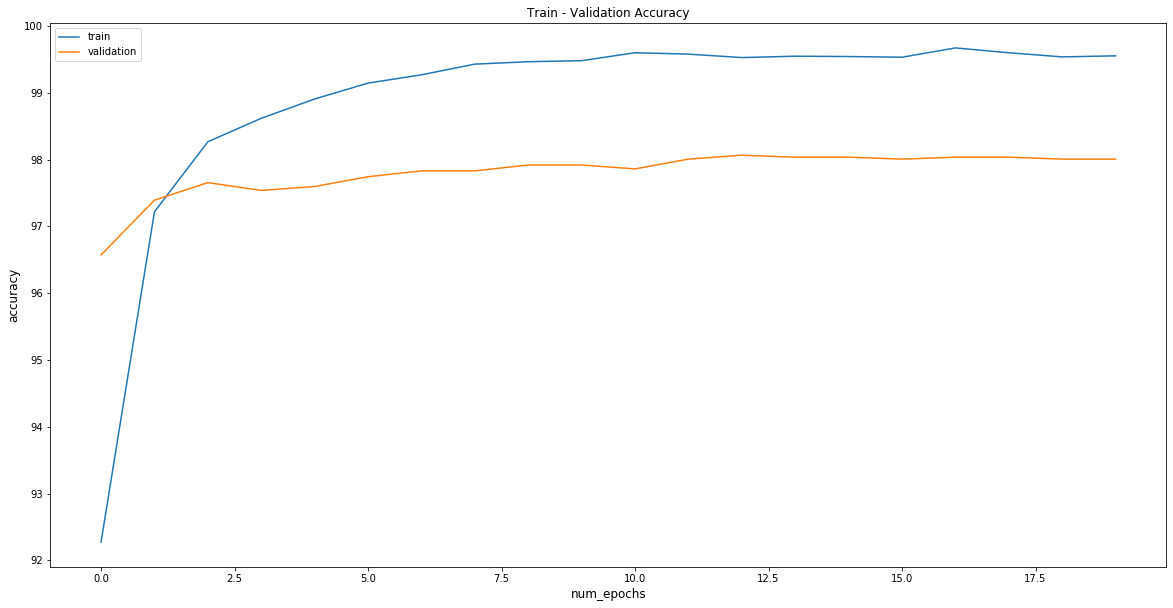

In [18]:
fig_accuracy = plt.figure(figsize=(20, 10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.savefig(name_training + '/accuracy.png', format='png',bbox_inches='tight')
plt.savefig(name_training + '/accuracy.pdf', format='pdf',bbox_inches='tight')

In [24]:
#net = SSWQ_V1(len(waste_types_df), dropout=0.5, 
                #hidden_layer1=512, hidden_layer2=2048)
#net = models.resnet34(pretrained=False)
net = EfficientNet.from_pretrained("efficientnet-b3",num_classes=len(waste_types_df))
#in_features = net.fc.in_features
#net.fc = nn.Linear(in_features, len(waste_types_df))
net.to(device)
net.load_state_dict(torch.load(name_training + '/model.pt'))
net.eval()

Loaded pretrained weights for efficientnet-b3


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
  

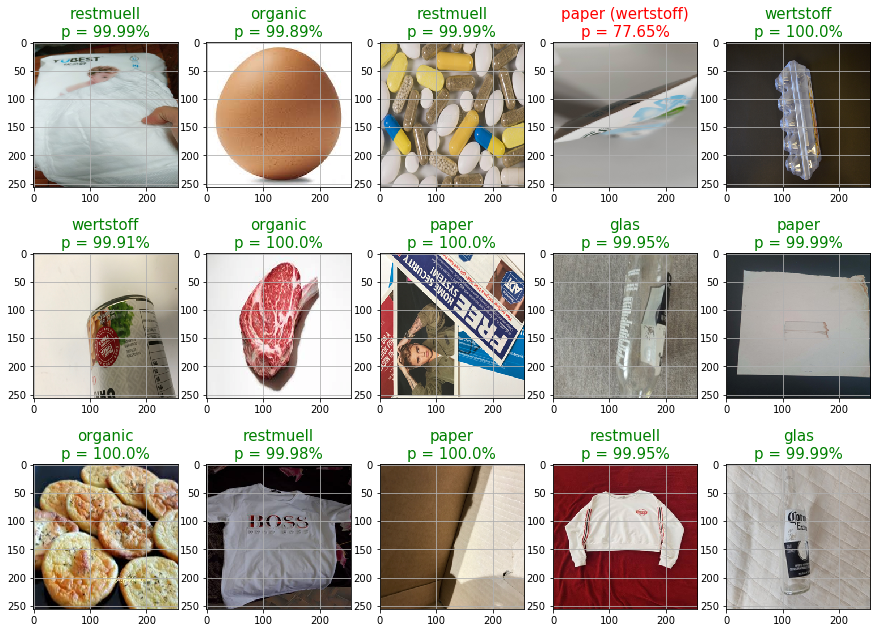

In [25]:
dataiter = iter(test_dataloader)
images, labels, path = dataiter.next()

# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 11))
with torch.no_grad():
    for ax, image, label, path in zip(axis.flat, images, labels, path):
        ax.grid(None)
        ax.set_facecolor((1,1,1))
        ax.imshow(img_display(image))  # add image
        image, label = image.to(device), label.to(device)
        imagetensor = image.unsqueeze(0)
        imagetensor.to(device)
        output = net(imagetensor)
        softmax = nn.LogSoftmax(1)
        output = softmax(output)
        outputnumpy = torch.exp(output).to('cpu').numpy()
        output = output.argmax()
        k = output.item() == label.item()
        color = 'green'
        highest_probability = str(round(100 * outputnumpy[0][output.item()], 2))
        string = str(garbage_types[output.item()]) + "\np = " + highest_probability + "%"
        if not k:
            color = 'red'
            string = str(garbage_types[output.item()]) + " (" + str(garbage_types[label.item()]) + ")\np = " + highest_probability + "%"
        ax.set_title(string, fontsize=15, color=color)  # add label

In [26]:
a = []
b = []
dict = {
    'paper':[0,0,0],
    'wertstoff':[0,0,0],
    'restmuell':[0,0,0],
    'glas':[0,0,0],
    'organic':[0,0,0],
}
with torch.no_grad():
    for data_t, target_t, _ in test_dataloader:
        target_t = target_t.type(torch.FloatTensor)
        data_t, target_t = data_t.to(device), target_t.to(device)  # on GPU
        for image, label in zip(data_t, target_t):
            imagetensor = image.unsqueeze_(0)
            imagetensor.to(device)
            output = net(image)
            output = output.argmax()
            k = output.item() == label.item()
            a.append(k)
            b.append(garbage_types[label.item()])
            # Absolute Count
            dict[garbage_types[label.item()]][0] += 1
            if k: # True
                dict[garbage_types[label.item()]][1] += 1
            else: # False
                dict[garbage_types[label.item()]][2] += 1

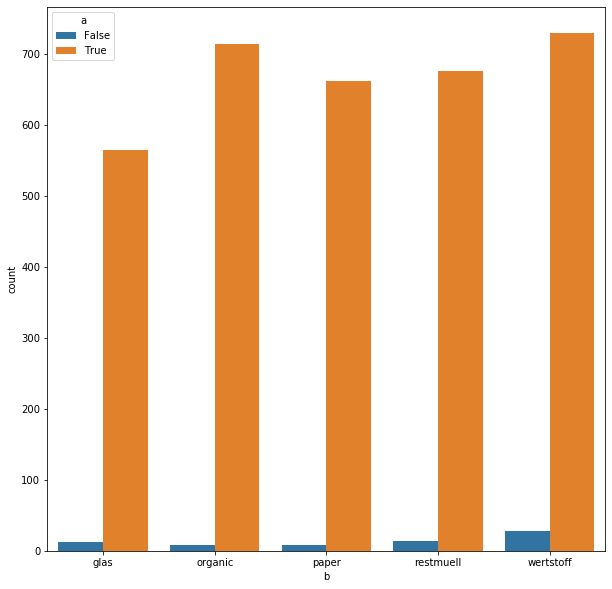

In [27]:
df = {"a":a, "b":b}
df = pd.DataFrame(df)
fig, ax1 = plt.subplots(figsize=(10, 10))
sns.countplot(x=df['b'], hue=df['a'], ax=ax1)
plt.savefig(name_training + '/countplot.png', format='png',bbox_inches='tight')
plt.savefig(name_training + '/countplot.pdf', format='pdf',bbox_inches='tight')

In [28]:
print(dict)

{'paper': [670, 662, 8], 'wertstoff': [757, 729, 28], 'restmuell': [690, 676, 14], 'glas': [577, 564, 13], 'organic': [721, 713, 8]}


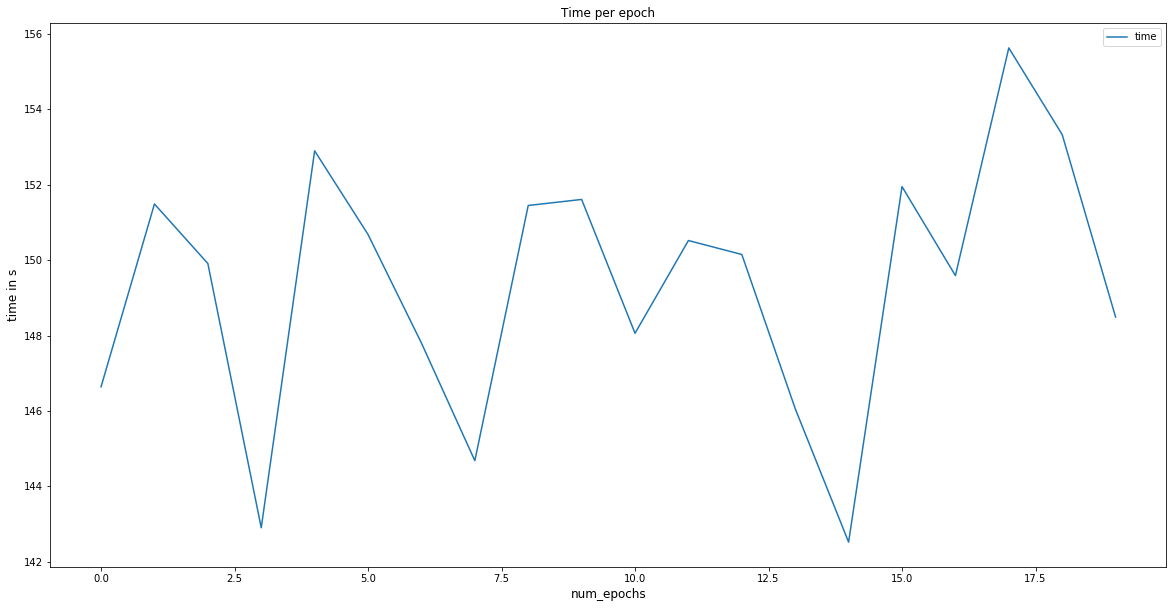

In [29]:
fig_time = plt.figure(figsize=(20, 10))
plt.title("Time per epoch")
plt.plot(time_per_epoch, label='time')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('time in s', fontsize=12)
plt.legend(loc='best')
plt.savefig(name_training + '/fig_time.png', format='png',bbox_inches='tight')
plt.savefig(name_training + '/fig_time.pdf', format='pdf',bbox_inches='tight')

In [30]:
sum = 0
for time in time_per_epoch:
     sum += time

avg_time = sum / len(time_per_epoch)
print(avg_time)

149.31799999999998
